In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric 
from torch_geometric.datasets import GeometricShapes
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np


In [98]:
tf = torch_geometric.transforms.FaceToEdge()
print(tf)
train_dataset = GeometricShapes(root='./GeometricShapes',train=True,pre_transform=tf)
test_dataset = GeometricShapes(root='./GeometricShapes',train=False,pre_transform=tf)
loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

train_dataset.process()
test_dataset.process()
# for batch in loader:
#     print(batch)
print(train_dataset[10])

FaceToEdge()
Data(edge_index=[2, 94], pos=[12, 3], y=[1])


[[0, 1], [0, 20], [1, 0], [1, 2], [1, 3], [1, 20], [2, 1], [2, 3], [3, 1], [3, 2], [3, 4], [3, 5], [3, 7], [3, 20], [4, 3], [4, 5], [5, 3], [5, 4], [5, 6], [5, 7], [6, 5], [6, 7], [7, 3], [7, 5], [7, 6], [7, 8], [7, 9], [7, 11], [7, 15], [7, 20], [7, 28], [8, 7], [8, 9], [9, 7], [9, 8], [9, 10], [9, 11], [10, 9], [10, 11], [11, 7], [11, 9], [11, 10], [11, 12], [11, 13], [11, 15], [12, 11], [12, 13], [13, 11], [13, 12], [13, 14], [13, 15], [14, 13], [14, 15], [15, 7], [15, 11], [15, 13], [15, 14], [15, 16], [15, 17], [15, 19], [15, 28], [16, 15], [16, 17], [17, 15], [17, 16], [17, 18], [17, 19], [18, 17], [18, 19], [19, 15], [19, 17], [19, 18], [19, 28], [19, 30], [19, 31], [20, 0], [20, 1], [20, 3], [20, 7], [20, 21], [20, 22], [20, 24], [20, 28], [21, 20], [21, 22], [22, 20], [22, 21], [22, 23], [22, 24], [23, 22], [23, 24], [24, 20], [24, 22], [24, 23], [24, 25], [24, 26], [24, 28], [25, 24], [25, 26], [26, 24], [26, 25], [26, 27], [26, 28], [27, 26], [27, 28], [28, 7], [28, 15], [28

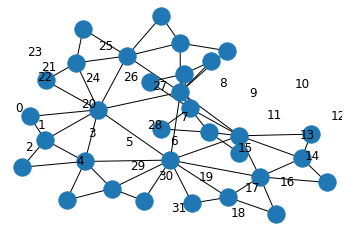

In [101]:
import networkx as nx
G = nx.Graph()
edge_list=[]
edges = np.array(train_dataset[0].edge_index)
for i in range(train_dataset[0].edge_index.size()[1]):
    edge_list.append([edges[0,i],edges[1,i]])
print(edge_list)
G.add_edges_from(edge_list)

fig, ax = plt.subplots()
pos=nx.spring_layout(G)
nx.draw(G)
nx.draw_networkx_labels(G,pos,ax=ax)
# ax.set_title('Class: {:f}'.format(label))
plt.show()

In [38]:
class Net(torch.nn.Module):
    def __init__(self,in_dim, hidden_dim, n_classes):
        super(Net, self).__init__()
#         self.lin = Sequential(Linear(10, 10))
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = torch.mean(x, 0, True)
        return self.classify(x)

In [52]:
training_epoch = 200 #original = 1500 for 1 training sample 500 for 20 samples
initial_lr = 0.01

In [53]:
# Create model
#model = Classifier(1, 256, trainset.num_classes)
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(3, 256, 6).to(device)
loss_func = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = initial_lr, momentum=0.9, weight_decay=5e-4)

model.train()

epoch_losses = []

#start timer:
t0 = time.time()

for epoch in range(training_epoch):
    model.train()
    epoch_loss = 0
    for iter, g in enumerate(loader):
        x = g.x.to(device)
        edges = g.edge_index.to(device)
        label = g.y.to(device)

        prediction = model(x,edges)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
#         print('loss {:.4f},label:{}'.format(loss,label))
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

training_time = time.time() - t0

print('Finished training. Training time = {:.4f} Seconds'.format(training_time))


Epoch 0, loss 1.8180
Epoch 1, loss 1.8122
Epoch 2, loss 1.7979
Epoch 3, loss 1.7948
Epoch 4, loss 1.7889
Epoch 5, loss 1.7817
Epoch 6, loss 1.7831
Epoch 7, loss 1.7757
Epoch 8, loss 1.7791
Epoch 9, loss 1.7888
Epoch 10, loss 1.7786
Epoch 11, loss 1.7768
Epoch 12, loss 1.7790
Epoch 13, loss 1.7619
Epoch 14, loss 1.7901
Epoch 15, loss 1.7860
Epoch 16, loss 1.7707
Epoch 17, loss 1.7753
Epoch 18, loss 1.7718
Epoch 19, loss 1.7659
Epoch 20, loss 1.7722
Epoch 21, loss 1.7713
Epoch 22, loss 1.7689
Epoch 23, loss 1.7781
Epoch 24, loss 1.7777
Epoch 25, loss 1.7704
Epoch 26, loss 1.7855
Epoch 27, loss 1.7696
Epoch 28, loss 1.7685
Epoch 29, loss 1.7672
Epoch 30, loss 1.7976
Epoch 31, loss 1.7789
Epoch 32, loss 1.7557
Epoch 33, loss 1.7580
Epoch 34, loss 1.7783
Epoch 35, loss 1.7644
Epoch 36, loss 1.7603
Epoch 37, loss 1.7592
Epoch 38, loss 1.7672
Epoch 39, loss 1.7603
Epoch 40, loss 1.7614
Epoch 41, loss 1.7659
Epoch 42, loss 1.7616
Epoch 43, loss 1.7558
Epoch 44, loss 1.7615
Epoch 45, loss 1.754

KeyboardInterrupt: 

True

(tensor([[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0